In [1]:
# imports
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from sklearn.metrics import accuracy_score
import torch.optim as optim
import glob
from torch.utils.data import Dataset, DataLoader
import math
import pandas as pd
import os
from os import listdir
from os.path import join, isfile
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler
from datetime import date, datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
# data class, tested and ready to use

class ParkinsonsDataset(Dataset):
    def __init__(self):
        
        pathLabels = 'data/bagData/labels_all.csv'
        
        self.pathFiles = 'data/bagData'
        
        self.y = pd.read_csv(pathLabels)
        
        self.label = self.y['filenames']
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        
        tempath = self.y.iloc[index]['filenames']
        
        signalpath = os.path.join(self.pathFiles,tempath)
        
        self.x = torch.from_numpy(np.load(signalpath).astype(np.double))
        #self.x =  self.x[:,:,[0,1,2]]
        
        return self.x, self.y.iloc[index]['binary']

In [3]:
# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.L = 16
        self.K = 1
        self.M = 64 
        ## feature extraction 
        self.featureExtract = nn.Sequential(nn.Conv1d(in_channels = 12 , out_channels = 32, kernel_size=8, padding =1,stride = 1),
                                            nn.LeakyReLU(negative_slope=0.2), 
                                            nn.MaxPool1d(2),
                                            nn.Conv1d(in_channels = 32,out_channels = 32, kernel_size=8,padding =1, stride = 1),
                                            nn.LeakyReLU(negative_slope=0.2),
                                            nn.MaxPool1d(2),
                                            nn.Conv1d(in_channels = 32, out_channels = 16, kernel_size=16, padding =1, stride = 1),
                                            nn.LeakyReLU(negative_slope=0.2),
                                            nn.MaxPool1d(2),
                                            nn.Conv1d(in_channels = 16, out_channels = 16, kernel_size=16, padding =1, stride = 1), 
                                            nn.LeakyReLU(negative_slope=0.2),
                                            nn.MaxPool1d(2),
                                            nn.Flatten(),
                                            nn.Linear(320, self.M)) 

        self.attention = nn.Sequential(nn.Linear(self.M, self.L),
                                       nn.Tanh(),
                                       nn.Linear(self.L, self.K))
                
        self.classify = nn.Sequential(nn.Linear(self.M,32), 
                                      nn.LeakyReLU(negative_slope=0.2),
                                      Dropout(p = 0.2, inplace = False), 
                                      nn.Linear(32,16),
                                      nn.LeakyReLU(negative_slope=0.2),
                                      Dropout(p = 0.2, inplace = False), 
                                      nn.Linear(16,2),
                                      nn.Softmax(dim = 1))

    def forward(self, x):
        ## feature extraction
        
        H = self.featureExtract(x)
            
        A = self.attention(H)
        A = torch.transpose(A,1,0)
        s = nn.Softmax(dim=1)
        A = s(A)
            
        z = torch.mm(A,H) # summing the product of attention and features 
        
        output = self.classify(z)

        #Y_hat = torch.ge(Y_prob,0.5).float()
        
        #Y_hat = torch.argmax(Y_prob, dim=1)
        output = self.classify(z)
        Y_prob , Y_hat = torch.max(output,dim=1)
        
        
        return Y_prob, Y_hat, A
    
   
    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        _, Y_hat, _ = self.forward(X)
        error = 1. - Y_hat.eq(Y).cpu().float().mean().item()
        return error, Y_hat
    
    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood = -1. * (Y * torch.log(Y_prob) + (1. - Y) * torch.log(1. - Y_prob))  # negative log bernoulli
        return neg_log_likelihood, A

In [4]:
path = '/Users/jiayihan/Documents/ResultsThesis/Good models/BothSidesSDG/27-10-2021-15-51trainModel.pth'

model = Net()
model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()


Net(
  (featureExtract): Sequential(
    (0): Conv1d(12, 32, kernel_size=(8,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 32, kernel_size=(8,), stride=(1,), padding=(1,))
    (4): LeakyReLU(negative_slope=0.2)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 16, kernel_size=(16,), stride=(1,), padding=(1,))
    (7): LeakyReLU(negative_slope=0.2)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(16, 16, kernel_size=(16,), stride=(1,), padding=(1,))
    (10): LeakyReLU(negative_slope=0.2)
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=320, out_features=64, bias=True)
  )
  (attention): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=T

In [34]:
# Initialize the dataloaders for training and test
batch_size = 1

pd_data = ParkinsonsDataset()

validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(pd_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = DataLoader(dataset = pd_data,  batch_size = batch_size, sampler = train_sampler)

test_loader = DataLoader(dataset = pd_data,  batch_size = batch_size, sampler = valid_sampler)



In [66]:
## take random sample
dataiter = iter(test_loader)

data_ = dataiter.next()

data, bag_label = data_

data, bag_label = Variable(data), Variable(bag_label)

data=torch.swapaxes(data,3,2)

data = torch.squeeze(data)

data, bag_label = data.type(torch.float), bag_label.type(torch.float)

In [46]:
Y_prob, Y_hat, A = model(data)

In [47]:
print(Y_hat)
print(bag_label)

tensor([0])
tensor([1.])


In [48]:
largeAttention = data[torch.argmax(A),:,:]
smallAttention = data[torch.argmin(A),:,:]

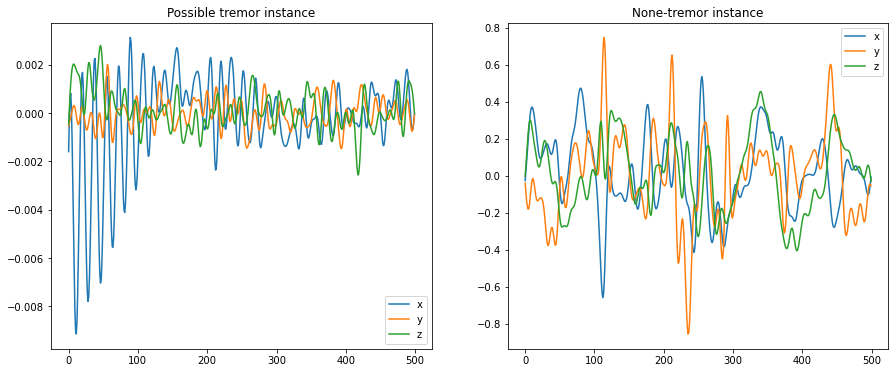

In [49]:
fig = plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(largeAttention[0,:])
plt.plot(largeAttention[1,:])
plt.plot(largeAttention[2,:])
plt.title('Possible tremor instance')
plt.legend(['x','y','z'])
plt.subplot(1,2,2)
plt.plot(smallAttention[0,:])
plt.plot(smallAttention[1,:])
plt.plot(smallAttention[2,:])
plt.title('None-tremor instance')
plt.legend(['x','y','z'])

#fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/AttentionResults.png')

In [138]:
labelpt = pd.read_csv('data/bagData/Labels_all.csv')
# 29_110016 
# 26_110016 - silvia 
# 67_110016
# 23_110017

In [220]:
test = torch.from_numpy(np.load('data/bagData/26_110016.npy').astype(np.float64))
test=torch.swapaxes(test,2,1)
test = test.type(torch.float)

In [221]:
Y_prob, Y_hat, A = model(test)
largeAttention = data[torch.argmax(A),:,:]
smallAttention = data[torch.argmin(A),:,:]
print(Y_hat)

tensor([1])


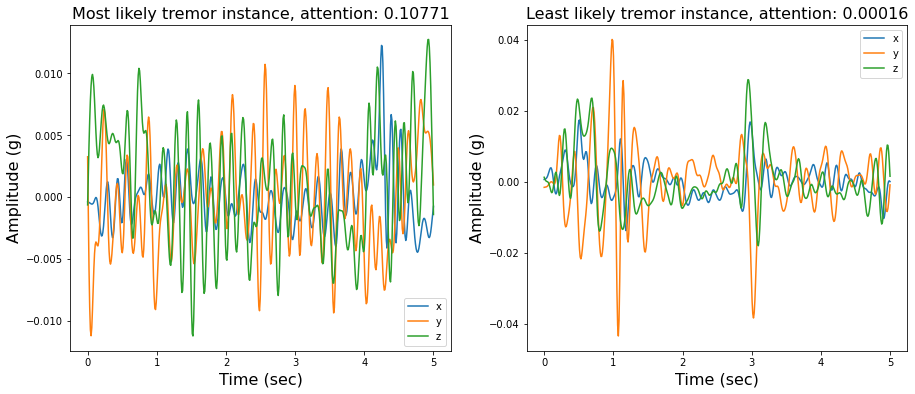

In [242]:
torch.set_printoptions(precision=3)

fig = plt.figure(figsize=(15,6))
time = np.linspace(0, 5, 500, endpoint=True)

plt.subplot(1,2,1)
plt.plot(time,largeAttention[0,:])
plt.plot(time,largeAttention[1,:])
plt.plot(time, largeAttention[2,:])
plt.title('Most likely tremor instance, attention: '+ str("{0:.5f}".format((torch.max(A).item()))), fontsize = 16)
plt.legend(['x','y','z'])
plt.xlabel('Time (sec)',fontsize = 16)
plt.ylabel('Amplitude (g)',fontsize = 16)


plt.subplot(1,2,2)
plt.plot(time,smallAttention[0,:])
plt.plot(time,smallAttention[1,:])
plt.plot(time,smallAttention[2,:])
plt.title('Least likely tremor instance, attention: '+  str("{0:.5f}".format((torch.min(A).item()))) ,fontsize = 16)
plt.legend(['x','y','z'])
plt.xlabel('Time (sec)',fontsize = 16)
plt.ylabel('Amplitude (g)',fontsize = 16)

fig.savefig('/Users/jiayihan/OneDrive - Danmarks Tekniske Universitet/Thesis/Thesis_figures/AttentionResults_modified.png')

In [223]:
Complete_test = torch.from_numpy(np.load('data/npy_sec/filt5sec_110016_trials.npy').astype(np.float64))



Text(0, 0.5, 'Amplitude (g)')

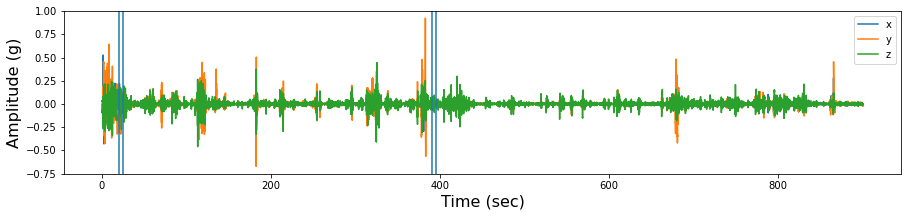

In [241]:
fig = plt.figure(figsize=(15,3))
time2 = np.linspace(0, 900, 90000, endpoint=True)

plt.plot(time2,torch.reshape(test[:,0,:],(-1,)))
plt.plot(time2,torch.reshape(test[:,1,:],(-1,)))
plt.plot(time2,torch.reshape(test[:,2,:],(-1,)))
plt.axvline(x=torch.argmin(A)*5)
plt.axvline(x=torch.argmin(A)*5-5)
plt.axvline(x=torch.argmax(A)*5) 
plt.axvline(x=torch.argmax(A)*5-5)
plt.legend(['x','y','z'])
plt.xlabel('Time (sec)',fontsize = 16)
plt.ylabel('Amplitude (g)',fontsize = 16)
